In [1]:

import sys  
sys.path.insert(0, '/Users/cwilson/desktop/programming/jupyter_tings/healthyride/healthyride')

from trip import Trip
import json

from plotting_funcs import Neighborhood_Plot


In [2]:
with open('../data.json') as f:
  json_list = json.load(f)
 

In [3]:
print(json_list[0])

{'Trip id': '107269366', 'Bikeid': '70529', 'To station name': 'S 18th St & Sidney St', 'Usertype': 'Subscriber', 'Stoptime': '10/1/2020 0:30', 'From station name': 'Atwood St & Bates St', 'Starttime': '10/1/2020 0:13', 'To station id': '1048', 'Tripduration': '1025', '_id': 1, 'From station id': '1039'}


In [4]:
#convert list of dicts to list of objects called "Trips"
Trip_list = []
for dict in json_list:
    li = list(dict.values())
    Trip_list.append(Trip(*li))

In [5]:
#test er out
print(Trip_list[420])
print(Trip_list[420].toname)
print(Trip_list[420].starttime)
print(Trip_list[420].weekday)
print(Trip_list[420].start_neighborhood)

Trip(tripid='107414962', bikeid='70303', toname='Stanton Ave & N Negley Ave', usertype='Customer', stoptime='10/2/2020 17:06', fromname='Butler St & 36th St', starttime='10/2/2020 16:43', toid='49401', tripduration='1357', _id=416, fromid='49951')
Stanton Ave & N Negley Ave
10/2/2020 16:43
4
Lawrenceville


In [6]:
clensed_Trip_list = [i for i in Trip_list if type(i.weekday) is int]
print(len(clensed_Trip_list))

567472


In [7]:
station_dict = {
    'Downtown': ['1000', '49701', '1002', '1001', '49691', '49671', '1056', '1003', 
                                '49731', '1004', '1006', '49651', '1010'],
    
    'Strip District': ['1016', '1017', '49611', '1059', '1060'],

    'East Liberty' : ['1026', '1027', '1029', '1024', '49391', '49371', '1064'],

    'Lawrenceville' : ['1061', '49581', '1019', '1020', '49501', '49951', '49561', '1018'],

    'North Shore' : ['49941', '49921', '1012', '1013'],

    'Central Northside' : ['1014', '1015', '49881'],

    'Southside Flats' : ['1074', '1049', '1048', '1047', '1046', '1045', '1084'],

    'Oakland' : ['1038', '1044', '1039', '1091', '1093', '1041', '1095', '1036', '1037', '1099', 
                        '1040', '1097', '1035', '1094', '49271'],
    
    'Squirrel Hill' : ['49251', '49261', '1068', '1069', '1070'],
    
    'Shadyside': ['1034', '1033', '1032', '1031'] 

}

/Users/cwilson/Desktop/Programming/jupyter_tings/HealthyRide/HealthyRide/neighborhood_analytics/plotting_funcs.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 7, figsize=(20,3), sharey = True)


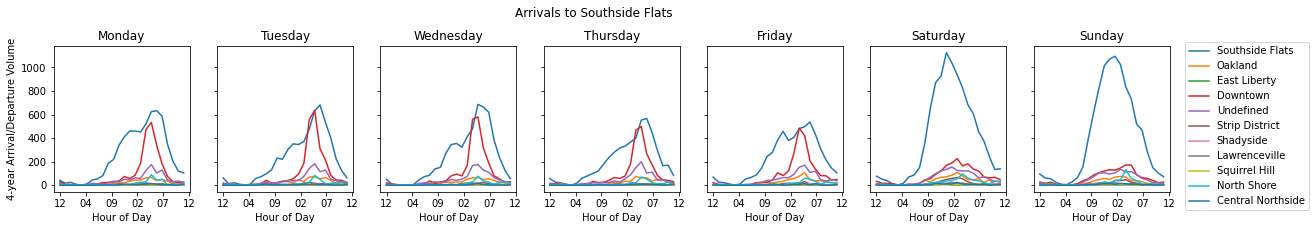

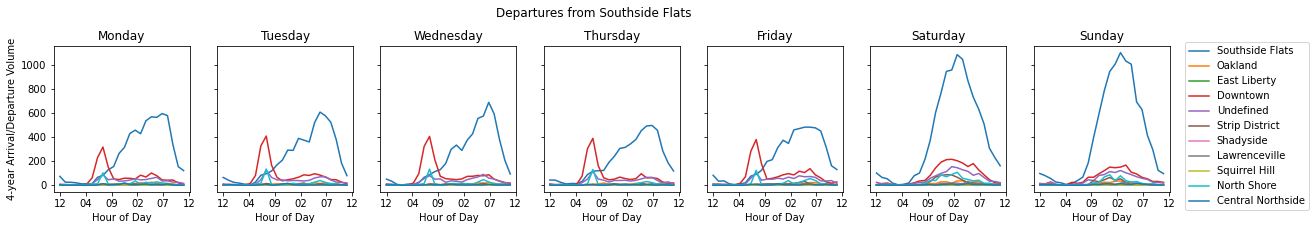

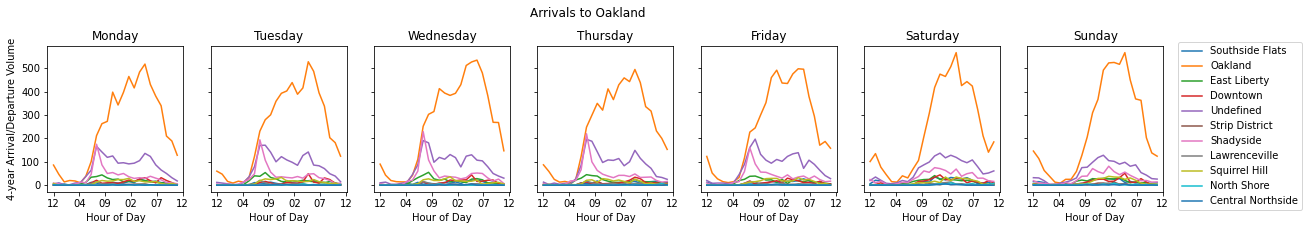

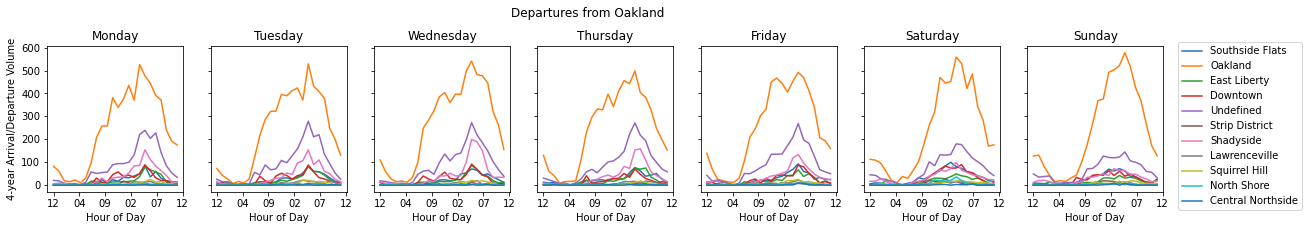

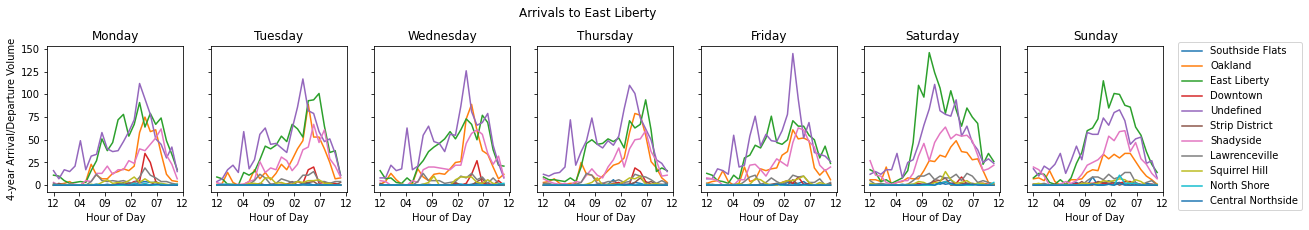

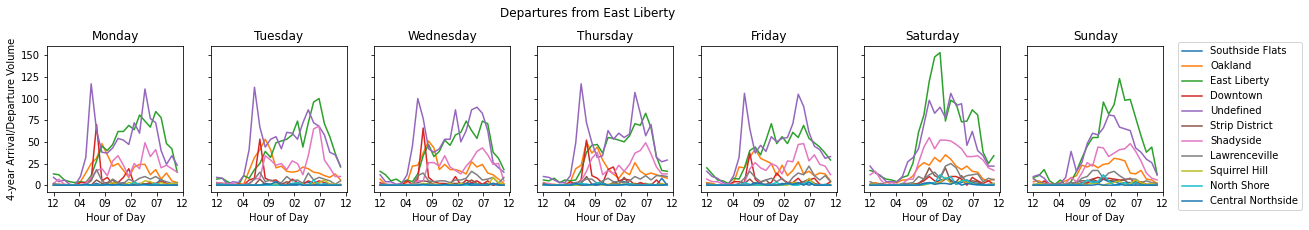

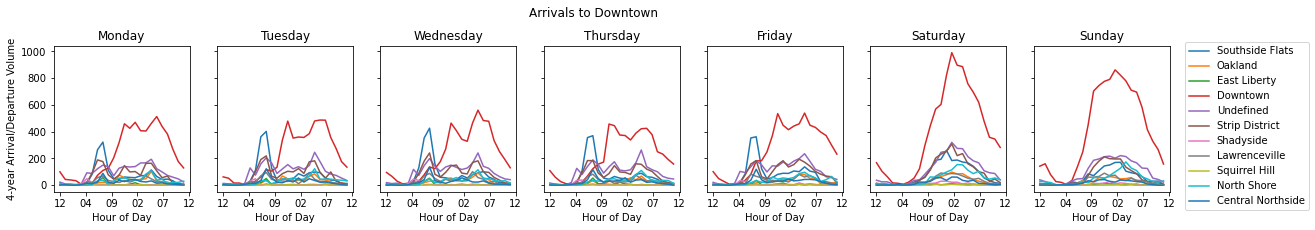

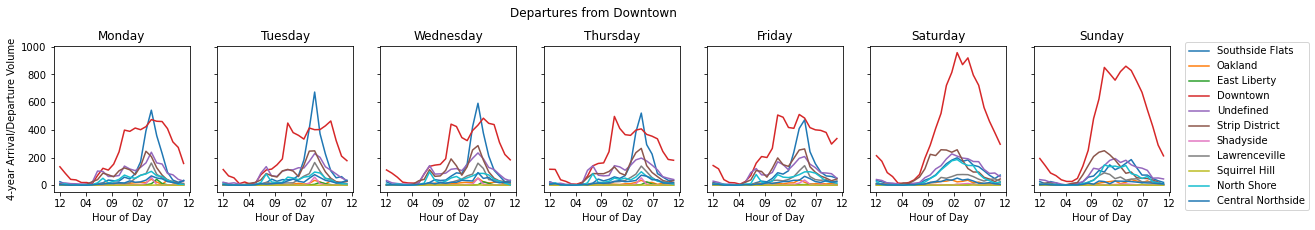

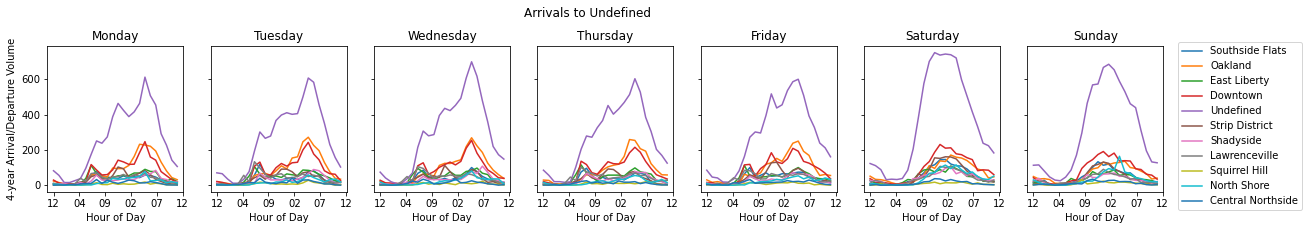

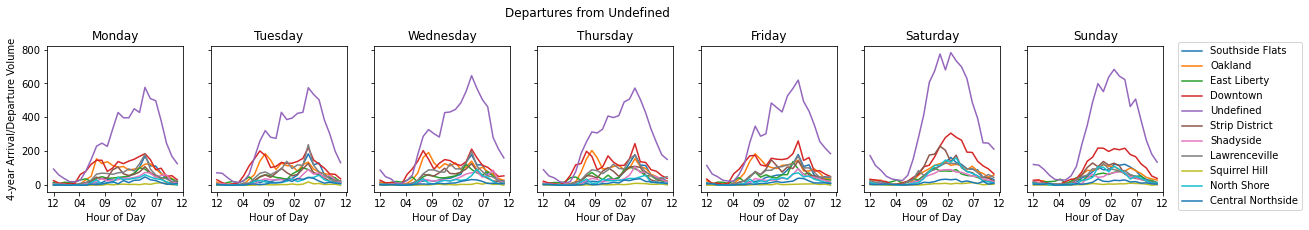

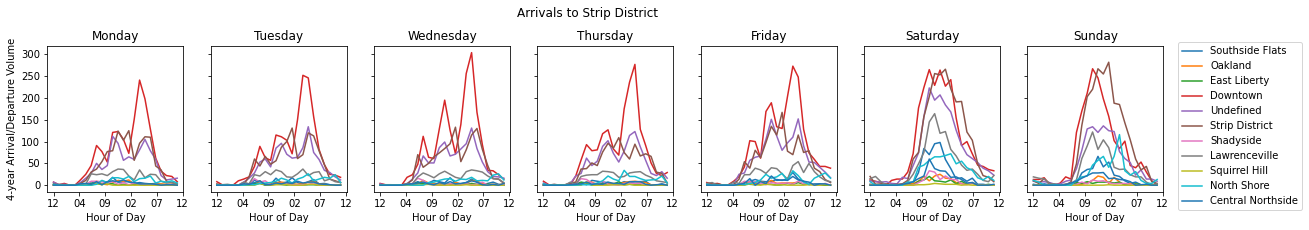

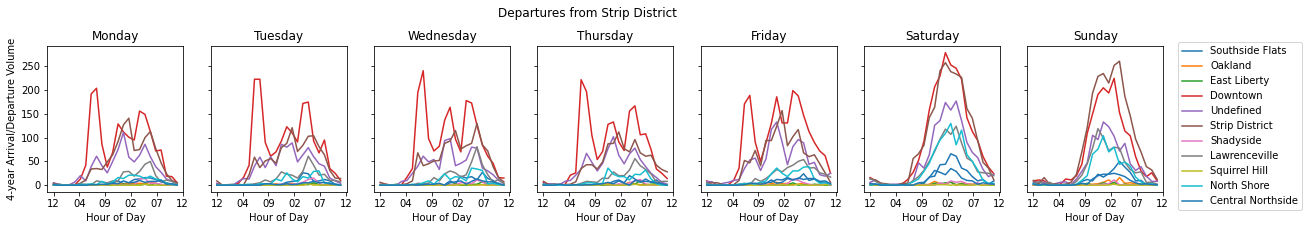

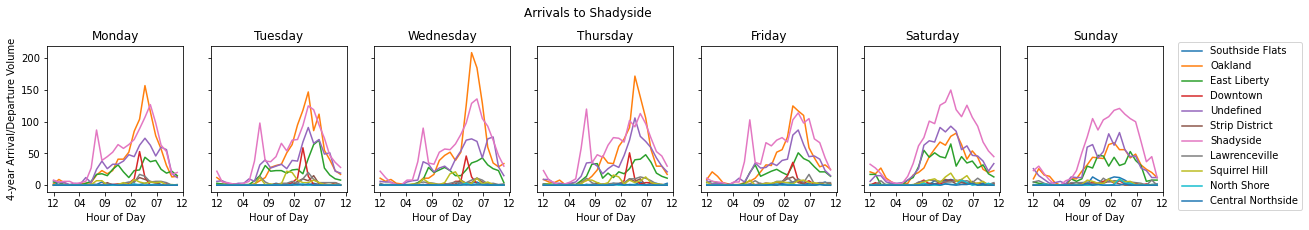

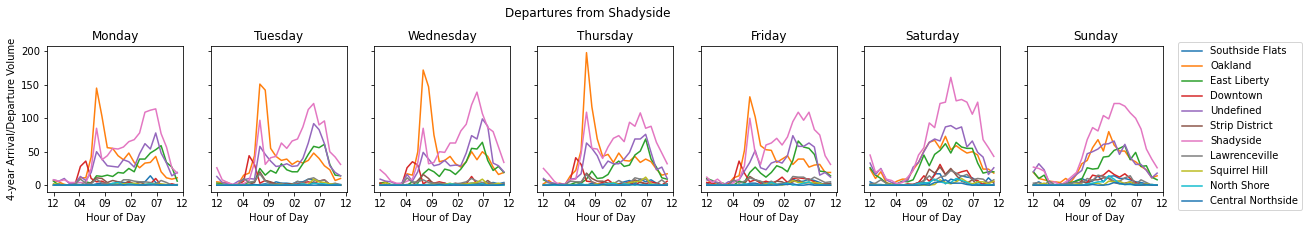

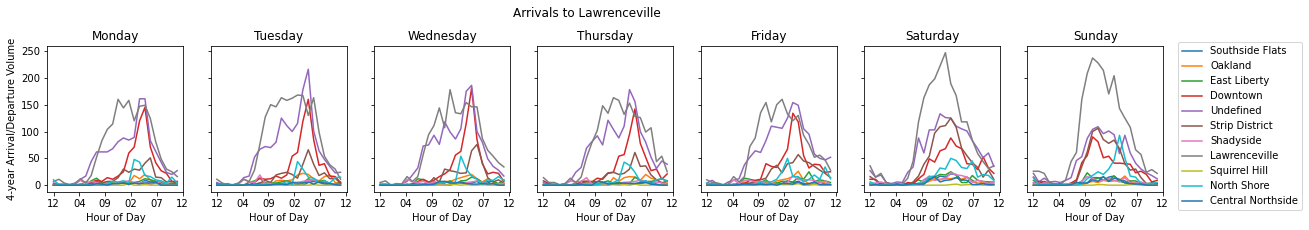

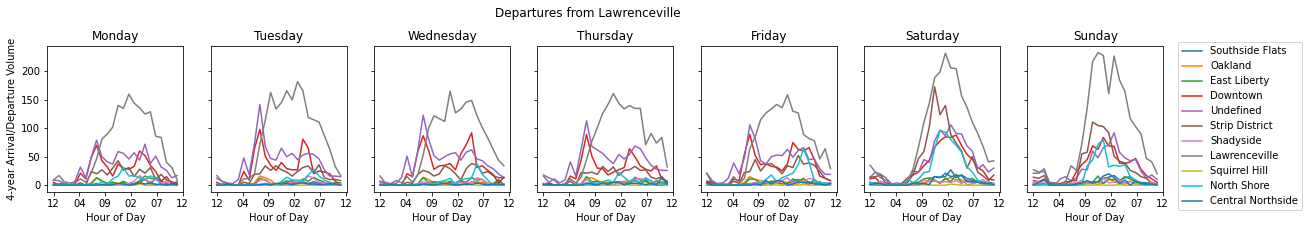

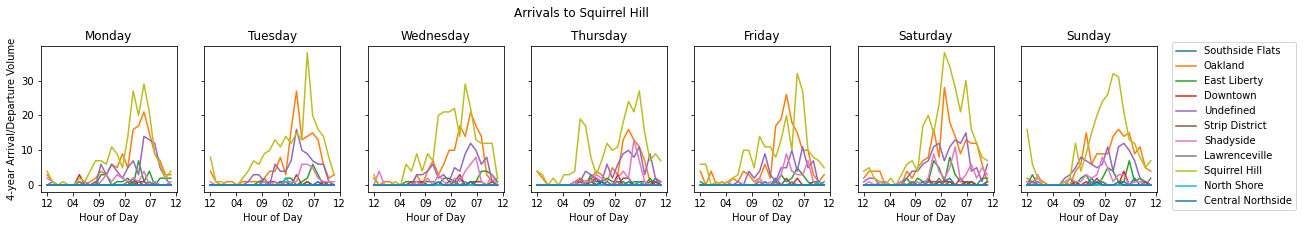

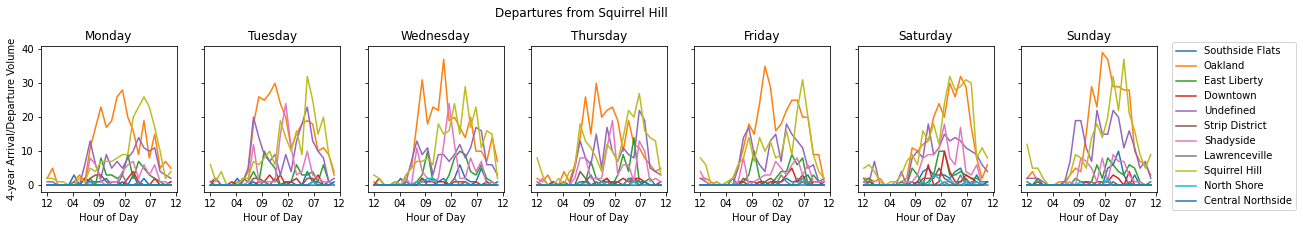

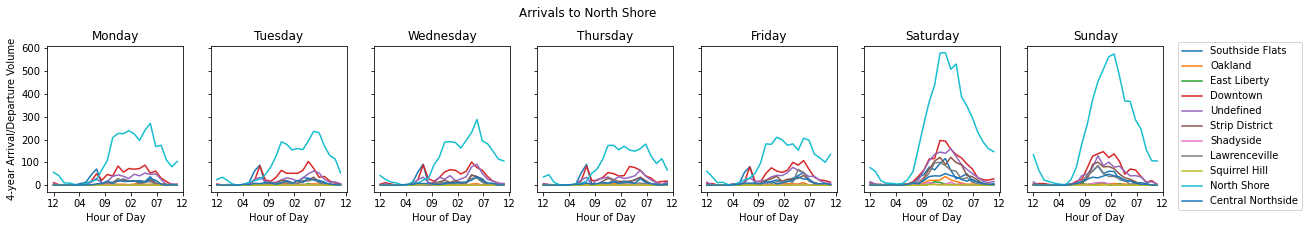

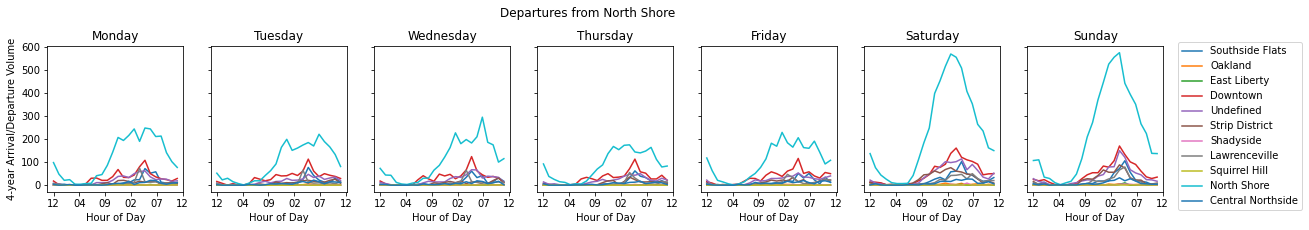

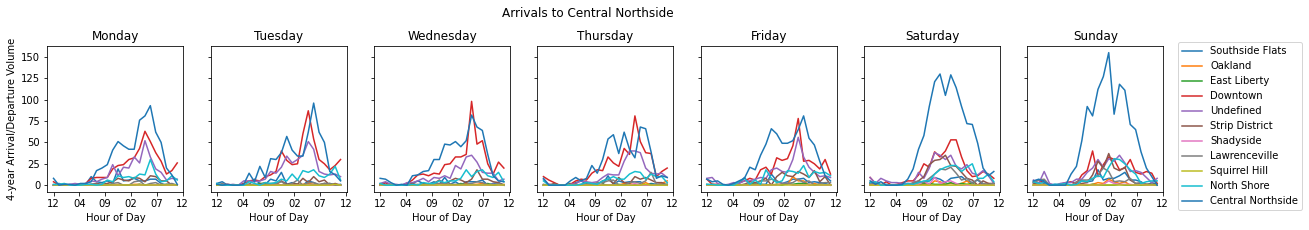

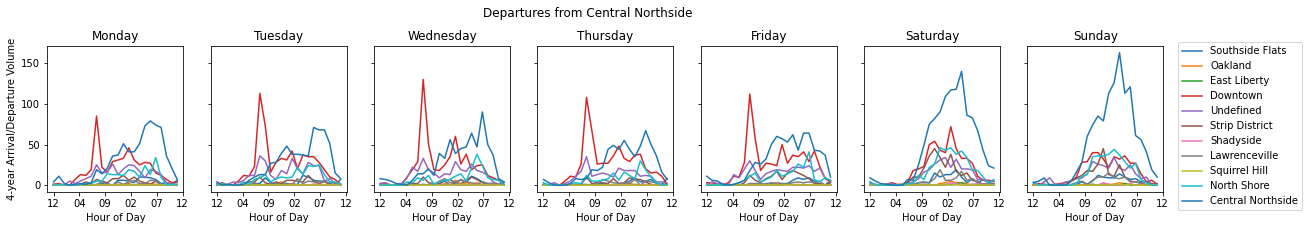

In [9]:
plot_object = Neighborhood_Plot(clensed_Trip_list)

plot_object.main_plot()